Assignment 8 - Adult Census Income (Metrics Report of Each Model)

This assignment focuses on building and comparing machine learning models to predict whether an individual's income exceeds $50,000 per year based on 1994 Census data. The project involves Data Engineering (cleaning and preparing the data), the implementation of three core algorithms—Decision Trees, Random Forests, and XGBoost—and the application of Hyperparameter Tuning to find the best model settings. A critical part of our study is the Metrics Analysis, where we evaluate each model using Accuracy, Precision, Recall, F1-Score, and ROC-AUC to ensure they are both balanced and reliable. Our final goal is to achieve high performance while using SHAP to understand the "why" behind the model's decisions, ensuring our AI is transparent and explainable.

PART 1 - Decision Trees – Theory & Implementation

In [86]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load data with 'auto' parser to handle types correctly
adult = fetch_openml('adult', version=2, as_frame=True, parser='auto')
df = adult.frame

# Shows data types and non-null counts
print("--- Initial Inspection ---")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

--- Initial Inspection ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None

First 5 rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [87]:
import numpy as np

# We check if '?' exists anywhere in the dataframe
print("Is '?' present in the data?", ('?' in df.values))

# If '?' is found, we replace it with NaN so all missing data is treated the same
df = df.replace('?', np.nan)

# Now we see the true total of missing values
print("\nTrue Missing values per column:")
print(df.isnull().sum())

Is '?' present in the data? False

True Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64


In [88]:
# We use .copy() to ensure we aren't working on a "view" of the data
df_cleaned = df.dropna().copy()

print(f"Original dataset rows: {len(df)}")
print(f"Rows after removing missing data: {len(df_cleaned)}")
print(f"Data retained: {(len(df_cleaned)/len(df)):.2%}")

Original dataset rows: 48842
Rows after removing missing data: 45222
Data retained: 92.59%


In [89]:
import numpy as np

# We apply log1p (log of 1 + x)
# Because log(0) is impossible. log(1+0) = 0.
df_cleaned['capital-gain'] = df_cleaned['capital-gain'].apply(np.log1p)
df_cleaned['capital-loss'] = df_cleaned['capital-loss'].apply(np.log1p)

print("Log Transformation complete. Skewed values have been 'squashed' for better learning.")

Log Transformation complete. Skewed values have been 'squashed' for better learning.


In [90]:
from sklearn.preprocessing import StandardScaler

# We identify the numerical columns that need scaling
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

scaler = StandardScaler()
df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

print("Scaling complete. All numerical features now have a mean of 0 and a standard deviation of 1.")
display(df_cleaned[num_cols].head())

Scaling complete. All numerical features now have a mean of 0 and a standard deviation of 1.


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-1.024983,0.350889,-1.221559,-0.300328,-0.222752,-0.078120
1,-0.041455,-0.945878,-0.438122,-0.300328,-0.222752,0.754701
2,-0.798015,1.393592,0.737034,-0.300328,-0.222752,-0.078120
3,0.412481,-0.278420,-0.046403,3.327301,-0.222752,-0.078120
5,-0.344079,0.084802,-1.613277,-0.300328,-0.222752,-0.910942


In [91]:
import pandas as pd

# 1. Target: Turn income into 1 (>50K) and 0 (<=50K)
# We strip spaces to ensure the text matches perfectly
df_cleaned['class'] = df_cleaned['class'].astype(str).str.strip()
df_cleaned['target'] = df_cleaned['class'].map({'>50K': 1, '<=50K': 0})

# 2. Selection: Drop text 'education' (redundant with education-num) and old 'class'
df_ml = df_cleaned.drop(columns=['class', 'education'])

# 3. One-Hot Encoding: Create binary columns for categories like Occupation or Race
df_final = pd.get_dummies(df_ml, drop_first=True)
df_final = df_final.astype(float)

print(f"Final dataset ready. Total features: {df_final.shape[1]}")
pd.set_option('display.max_columns', 100)
display(df_final.head())

Final dataset ready. Total features: 83


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-1.024983,0.350889,-1.221559,-0.300328,-0.222752,-0.078120,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.041455,-0.945878,-0.438122,-0.300328,-0.222752,0.754701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.798015,1.393592,0.737034,-0.300328,-0.222752,-0.078120,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.412481,-0.278420,-0.046403,3.327301,-0.222752,-0.078120,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,-0.344079,0.084802,-1.613277,-0.300328,-0.222752,-0.910942,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [92]:
from sklearn.model_selection import train_test_split

# Separate Features (X) from Target (y)
X = df_final.drop(columns=['target'])
y = df_final['target']

# Split: 80% for Training, 20% for the Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows")

Training set: 36177 rows
Testing set: 9045 rows


In [93]:
from sklearn.tree import DecisionTreeClassifier

# We set max_depth=5 to stop the tree from growing too complex (Memorization/Overfitting)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=5)

# The model 'fits' its logic to the training data
dt_model.fit(X_train, y_train)

print("Decision Tree training complete.")

Decision Tree training complete.


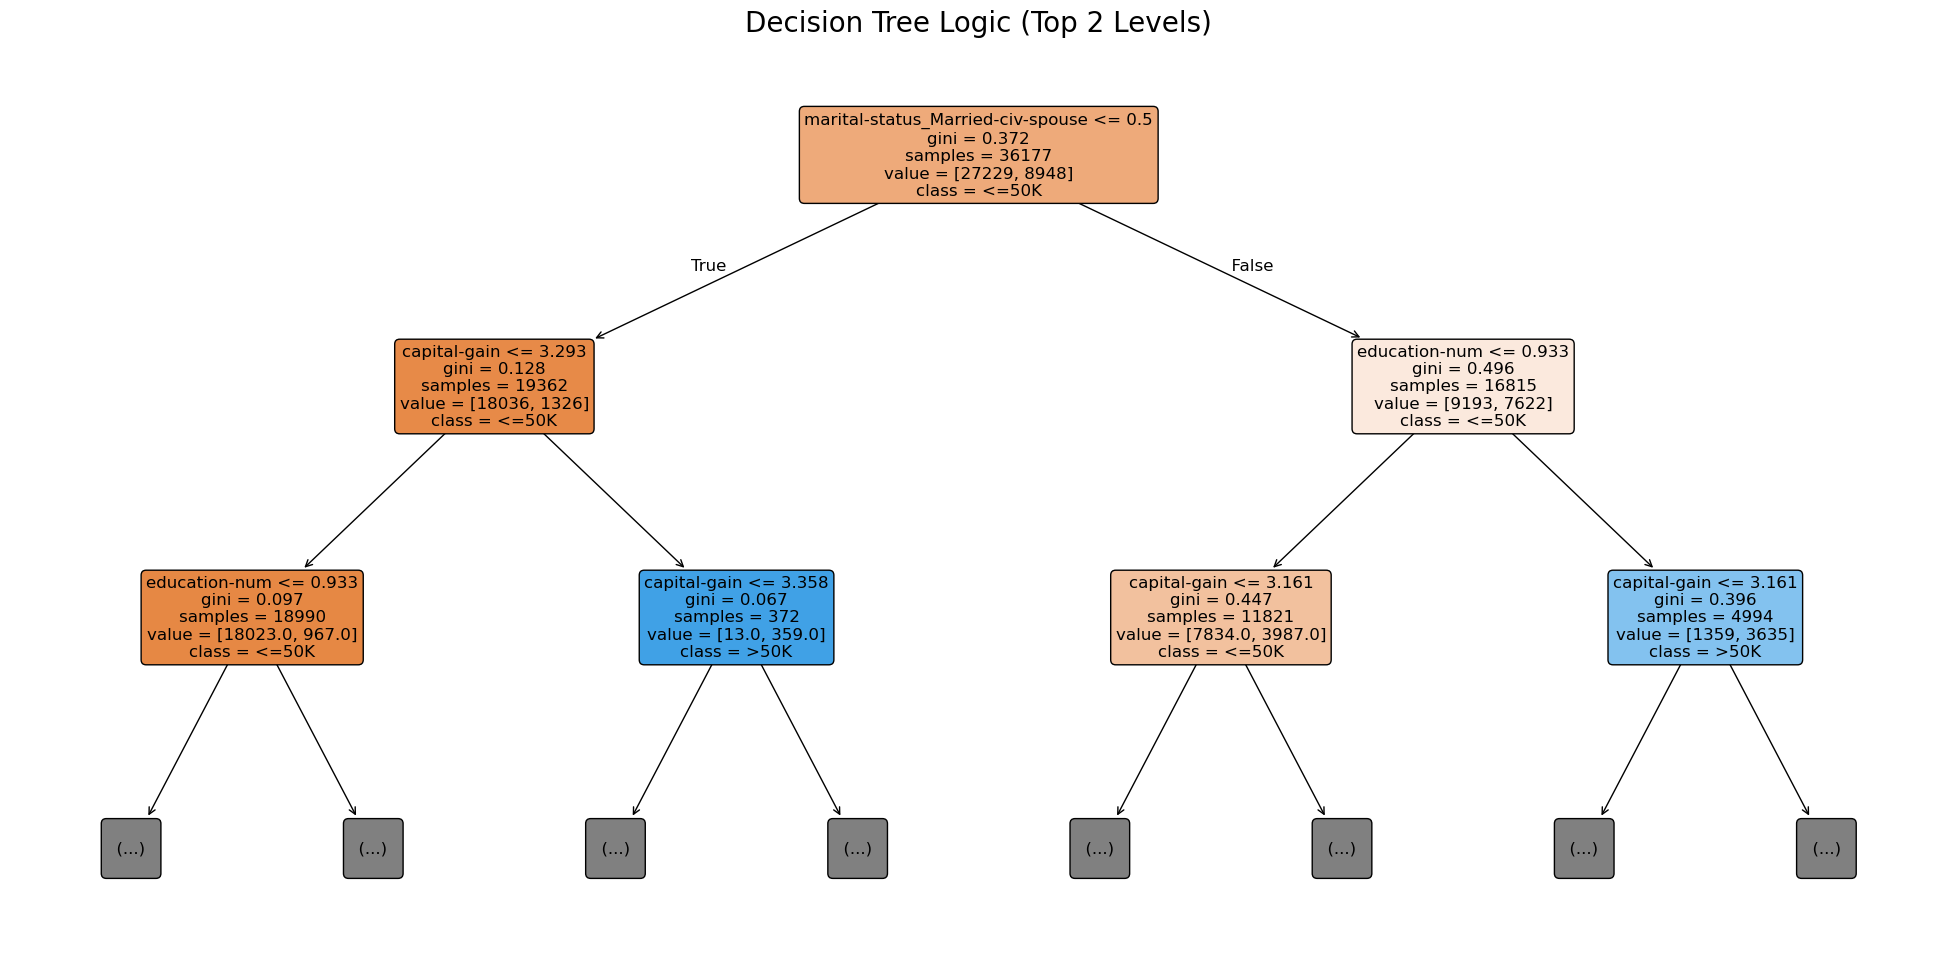

In [94]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Created a large figure so we can see the details
plt.figure(figsize=(25, 12))

# We plot the tree. 
# feature_names=X.columns tells us which questions the tree is asking (e.g., is age > 30?)
# class_names=['<=50K', '>50K'] tells us what the answer is at the end of the branch
# filled=True colors the boxes (Blue for high income, Orange for low income)
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          fontsize=12,
          max_depth=2)

plt.title("Decision Tree Logic (Top 2 Levels)", fontsize=20)
plt.show()

--- Model 1: Initial Decision Tree Metrics ---
Accuracy:  84.43%
Precision: 78.40%
Recall:    52.04%
F1-Score:  62.55%
ROC-AUC:   0.8787


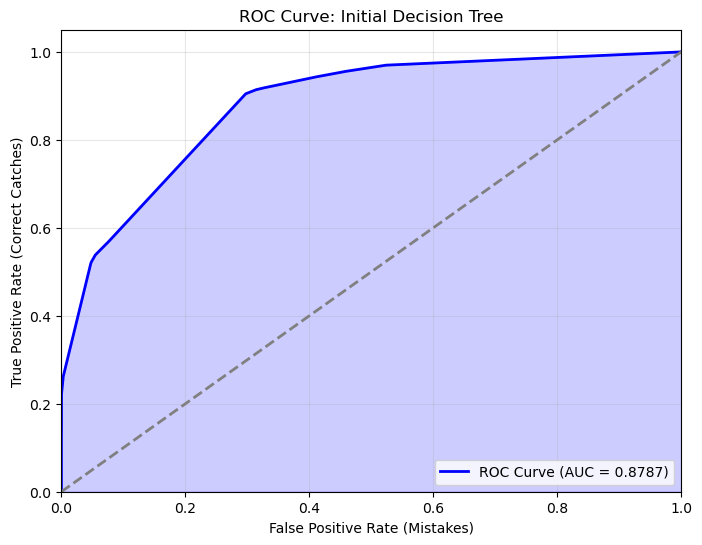

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Get predictions and probabilities
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

# 2. Print the text results
print("--- Model 1: Initial Decision Tree Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall:    {recall_score(y_test, y_pred):.2%}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.2%}")
print(f"ROC-AUC:   {auc_score:.4f}")

# 3. Create the ROC Curve Plot with Highlighted Area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
# Plot the main blue line
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')

# Fill the area under the curve
plt.fill_between(fpr, tpr, color='blue', alpha=0.2) 

# Plot the "Random Guesser" diagonal line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Formatting the chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Mistakes)')
plt.ylabel('True Positive Rate (Correct Catches)')
plt.title('ROC Curve: Initial Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Accuracy:  84.43% - This is High Accuracy because in our dataset most of people about 75% have the income smaller then $50k due to which model almost every time prediciting Low income which lead to high accuracy 

Precision: 78.40% - This tells that our model is 78% sure when pointed to a person that in which caterogry that person lies 

Recall: 52.04% - This shows our model only caught about 52% people who are making more then $50k. this is low because we are using here only single decision tree 

F1-Score: 62.55% - This is the average of precision and recall so due to low recall our overall F1 score is also got down 

ROC-AUC: 0.8787 - This score tells us that our model is 0.87 times greater then guessing random output for the person income 

<Figure size 800x600 with 0 Axes>

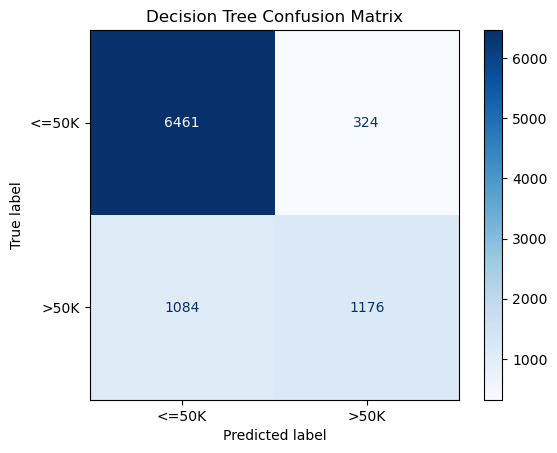

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Create the confusion matrix math
cm = confusion_matrix(y_test, y_pred)

# 2. Display it visually
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Decision Tree Confusion Matrix")
plt.show()

Part 2 - Random Forests & Ensembles

In [97]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators=100 means we are building a 'committee' of 100 trees
# max_depth=10 gives the trees a bit more room to learn than our single tree had
# random_state=5 ensures we get the same 'random' result every time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=5)

# Training the forest (this might take a second longer than a single tree)
rf_model.fit(X_train, y_train)

print("Random Forest training complete with 100 trees.")

Random Forest training complete with 100 trees.


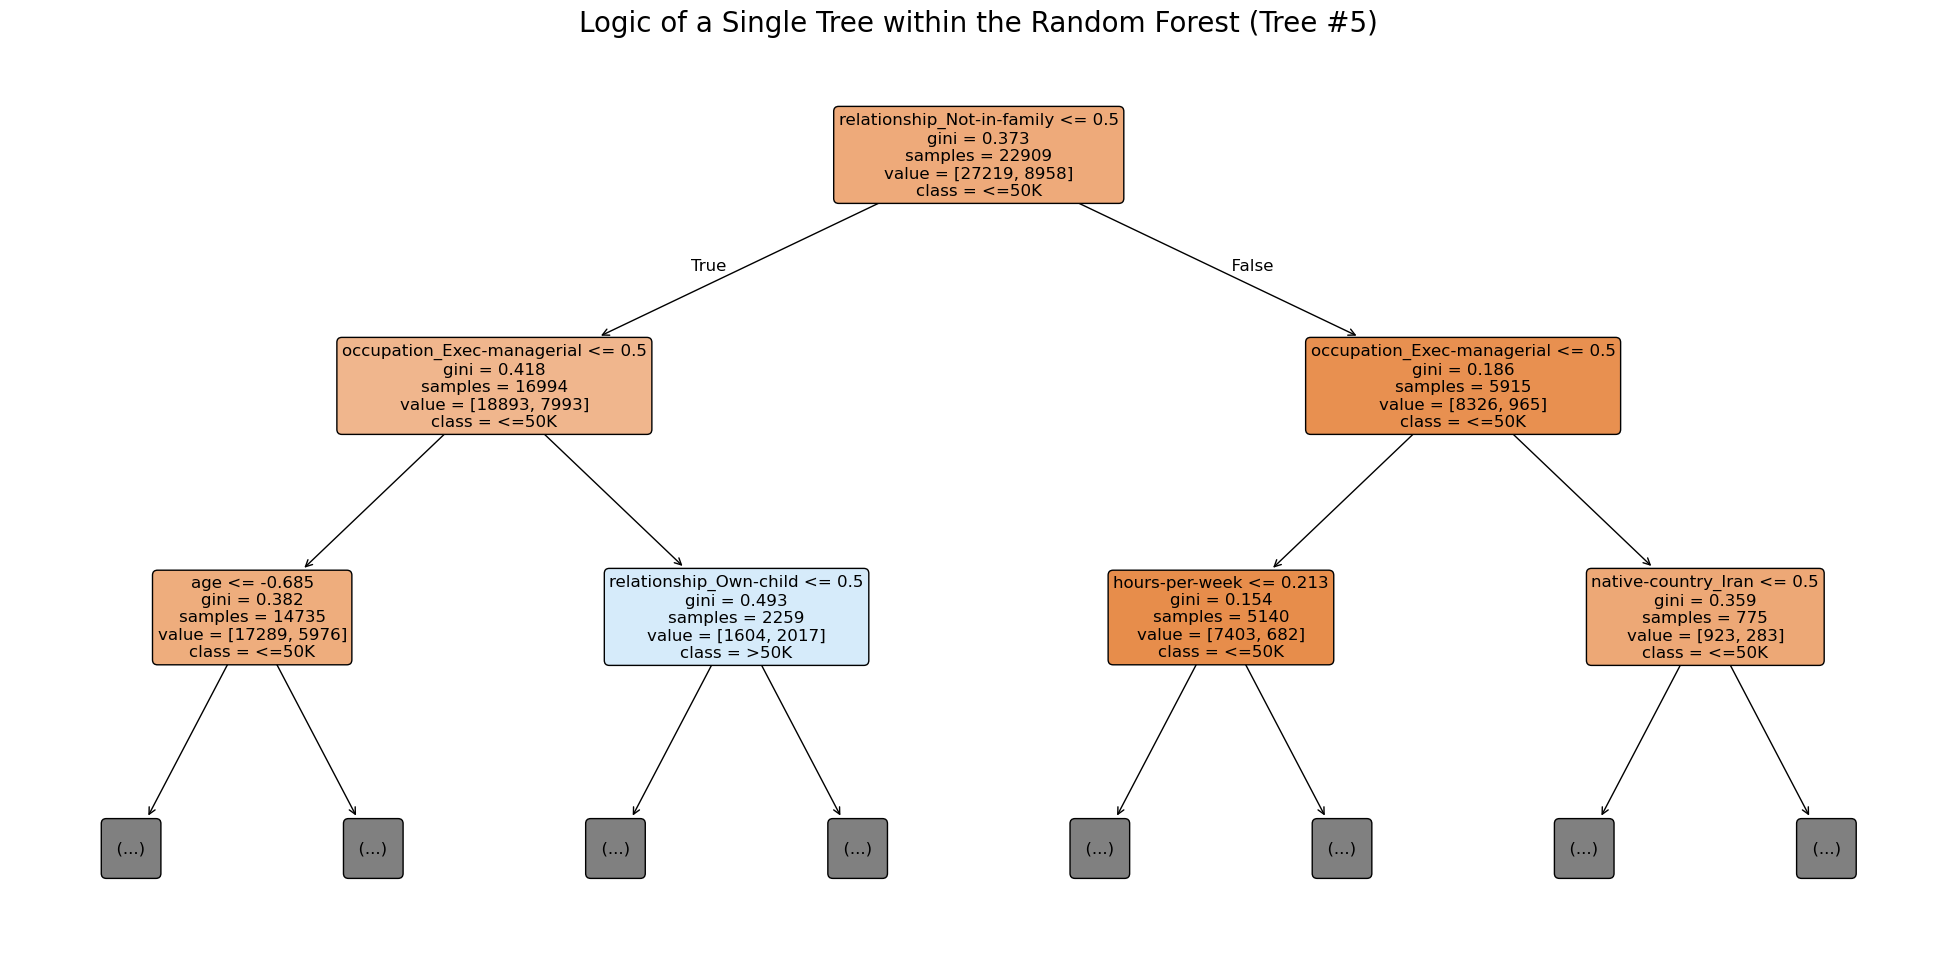

In [98]:
from sklearn.tree import plot_tree

# We pick the 5th tree from our forest of 100
sample_tree = rf_model.estimators_[5]

plt.figure(figsize=(25, 12))
plot_tree(sample_tree, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          max_depth=2, 
          fontsize=12)

plt.title("Logic of a Single Tree within the Random Forest (Tree #5)", fontsize=20)
plt.show()

--- Model 2: Random Forest Metrics ---
Accuracy:  85.42%
Precision: 80.73%
Recall:    54.69%
F1-Score:  65.21%
ROC-AUC:   0.9100


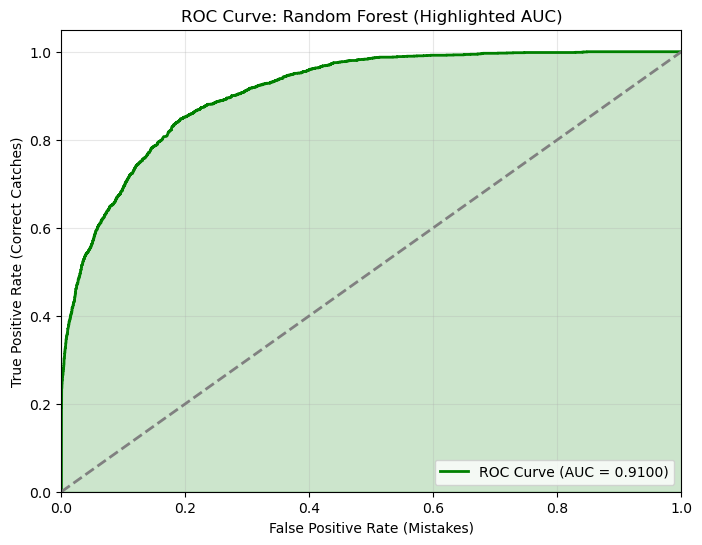

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Get predictions and probabilities for Random Forest
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)

# 2. Print the text results
print("--- Model 2: Random Forest Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, rf_pred):.2%}")
print(f"Precision: {precision_score(y_test, rf_pred):.2%}")
print(f"Recall:    {recall_score(y_test, rf_pred):.2%}")
print(f"F1-Score:  {f1_score(y_test, rf_pred):.2%}")
print(f"ROC-AUC:   {rf_auc:.4f}")

# 3. Create the ROC Curve Plot with Highlighted Area
fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)

plt.figure(figsize=(8, 6))
# Plot the main green line (Standard for Random Forest)
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC Curve (AUC = {rf_auc:.4f})')

# Fill the area under the curve to highlight the AUC
plt.fill_between(fpr, tpr, color='green', alpha=0.2) 

# Plot the "Random Guesser" diagonal line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Formatting the chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Mistakes)')
plt.ylabel('True Positive Rate (Correct Catches)')
plt.title('ROC Curve: Random Forest (Highlighted AUC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Accuracy: 85.42% - Now we have slightly more accuracy then the decision tree because now here we are using the 100 decision tree due to which now we less likly to fooled by strange outliers which is ultimatly leading to more stable overall score

Precision: 80.73% - This tells that our model is 80% sure when pointed to a person that person lies in above $50k catorgy. this is nice jump because after voting down all 100 trees this result came up 

Recall: 54.69% - This shows our model only caught about 54% people who are making more then $50k. 

F1-Score: 65.21% - This is the average of precision and recall so due to low recall our overall F1 score is also got down 

ROC-AUC: 0.9100 - This score tells us that our model is 0.91 times greater then guessing random output for the person income 

<Figure size 800x600 with 0 Axes>

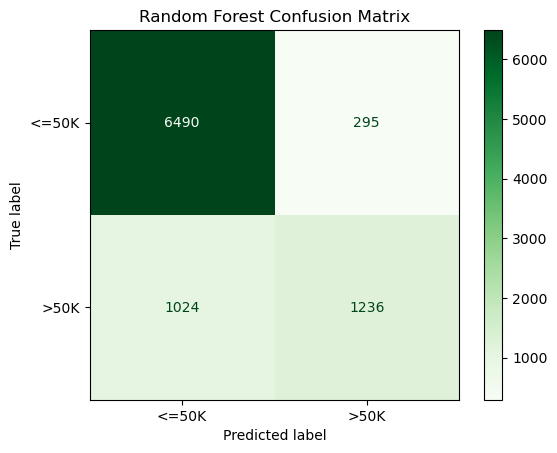

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the math
rf_cm = confusion_matrix(y_test, rf_pred)

# Display it
plt.figure(figsize=(8, 6))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['<=50K', '>50K'])
disp_rf.plot(cmap='Greens', values_format='d')

plt.title("Random Forest Confusion Matrix")
plt.show()

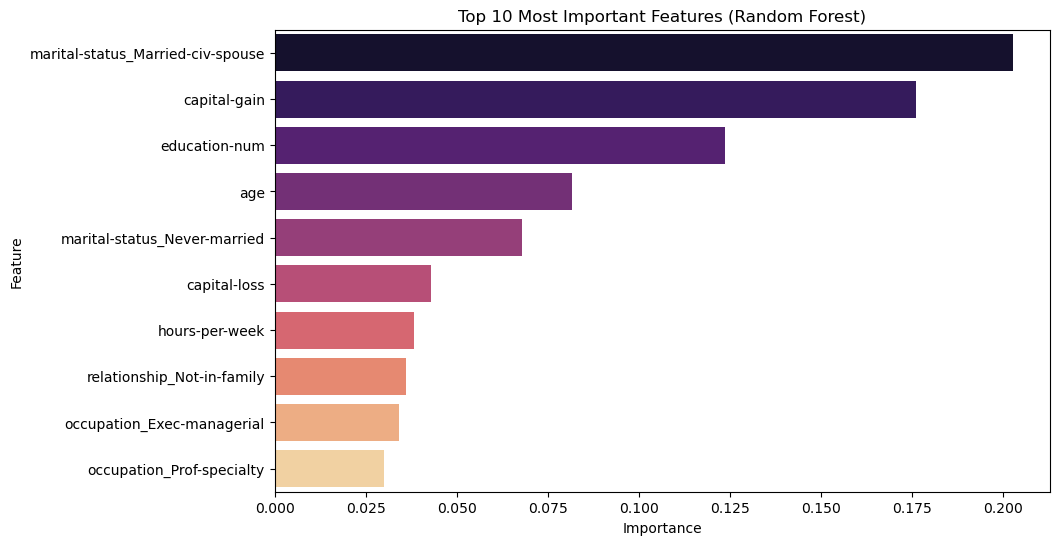

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the importance scores
importances = rf_model.feature_importances_
feature_names = X.columns

# Organize into a DataFrame
feat_import_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feat_import_df, 
    palette='magma', 
    hue='Feature', 
    legend=False
)
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()

Part 3 - Gradient Boosting (XGBoost)

In [102]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [103]:
import xgboost as xgb

# We initialize the XGBClassifier
# n_estimators=100: We build 100 trees sequentially
# learning_rate=0.1: We learn at a moderate pace to ensure accuracy
# max_depth=5: We keep individual trees simple
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Training
xgb_model.fit(X_train, y_train)

print("XGBoost training complete.")

XGBoost training complete.


--- Model 3: XGBoost Metrics ---
Accuracy:  86.62%
Precision: 79.10%
Recall:    63.14%
F1-Score:  70.23%
ROC-AUC:   0.9254


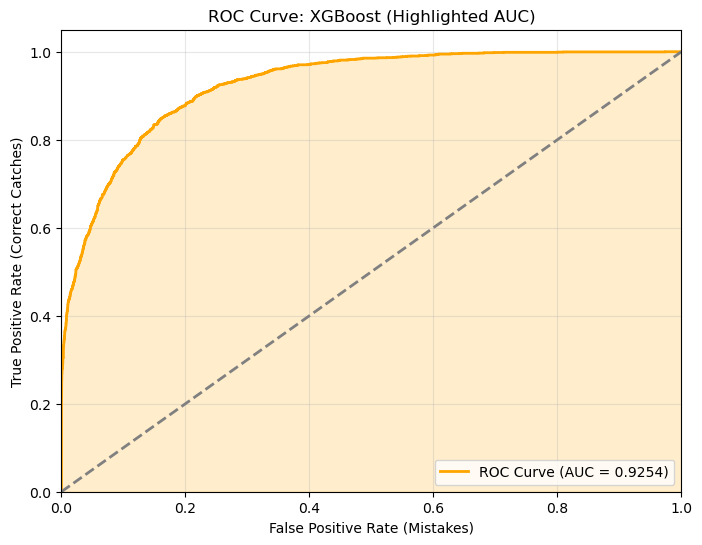

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Get predictions and probabilities for XGBoost
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

# 2. Print the text results
print("--- Model 3: XGBoost Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.2%}")
print(f"Precision: {precision_score(y_test, xgb_pred):.2%}")
print(f"Recall:    {recall_score(y_test, xgb_pred):.2%}")
print(f"F1-Score:  {f1_score(y_test, xgb_pred):.2%}")
print(f"ROC-AUC:   {xgb_auc:.4f}")

# 3. Create the ROC Curve Plot with Highlighted Area
fpr, tpr, _ = roc_curve(y_test, xgb_pred_proba)

plt.figure(figsize=(8, 6))
# Plot the main orange line (Standard for XGBoost)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC Curve (AUC = {xgb_auc:.4f})')

# Fill the area under the curve to highlight the AUC
plt.fill_between(fpr, tpr, color='orange', alpha=0.2) 

# Plot the "Random Guesser" diagonal line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Formatting the chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Mistakes)')
plt.ylabel('True Positive Rate (Correct Catches)')
plt.title('ROC Curve: XGBoost (Highlighted AUC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Accuracy: 86.62% - This is the Highest accuracy so far as the model learning from the past mistake model due to which model become more accurate at finding which person lies in which category 

Precision: 79.10% - This tells that our model is 79% sure when pointed to a person that person lies in above $50k catorgy. this is lower then the precision of random forest because here model is becoming little bit more agressive in trying to find high income people due to which sometimes it is catching people which are not above $50k. 

Recall: 63.14% - This is biggest jump in the recall section so far. now our model is significatly better at catching people who is rich but don't look like it to the previous models. now our recall is jumped to 63% from 50% 

F1-Score: 70.23% - This is the average of precision and recall and this is our first model to cross the 70% mark because now our recall is also increased which is low in previous models 

ROC-AUC: 0.9254 - This score tells us that our model is 0.92 times greater then guessing random output for the person income 

<Figure size 800x600 with 0 Axes>

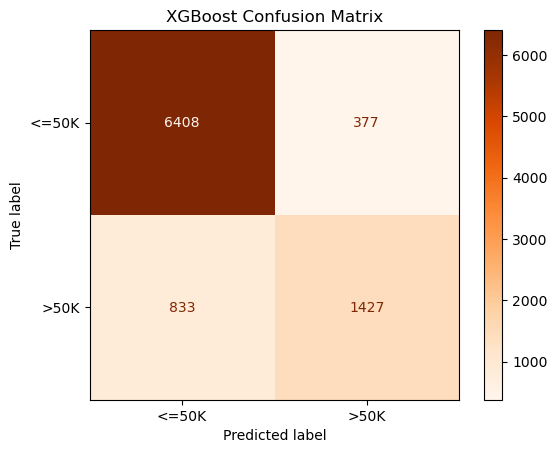

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Create the confusion matrix for XGBoost
xgb_cm = confusion_matrix(y_test, xgb_pred)

# 2. Display it
plt.figure(figsize=(8, 6))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['<=50K', '>50K'])
disp_xgb.plot(cmap='Oranges', values_format='d')

plt.title("XGBoost Confusion Matrix")
plt.show()

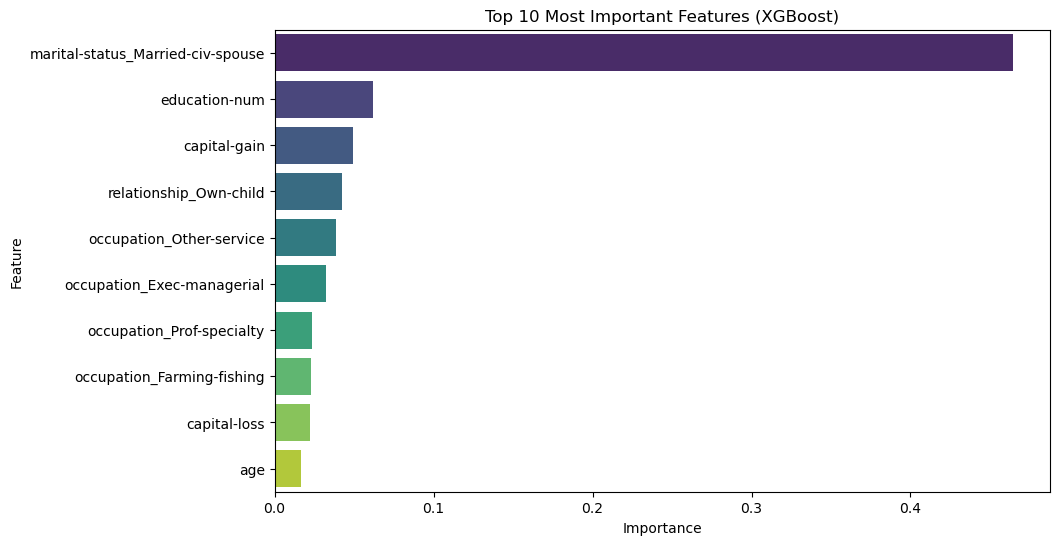

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost has a built-in property for feature importances
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame for visualization
xgb_feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances})
xgb_feat_df = xgb_feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=xgb_feat_df, 
    palette='viridis', 
    hue='Feature', 
    legend=False
)
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

In [107]:
import pandas as pd

# Creating a summary of our journey
results_data = {
    "Model": ["Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, rf_pred), accuracy_score(y_test, xgb_pred)],
    "Precision": [precision_score(y_test, y_pred), precision_score(y_test, rf_pred), precision_score(y_test, xgb_pred)],
    "Recall": [recall_score(y_test, y_pred), recall_score(y_test, rf_pred), recall_score(y_test, xgb_pred)]
}

comparison_df = pd.DataFrame(results_data)

# Show the table
print("--- Model Comparison Table ---")
display(comparison_df)

--- Model Comparison Table ---


,Model,Accuracy,Precision,Recall
0,Decision Tree,0.844334,0.784000,0.520354
1,Random Forest,0.854174,0.807315,0.546903
2,XGBoost,0.866224,0.791020,0.631416


Part 4 - Hyperparameter Tuning & Interpretability

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. Define the 'Grid' (The different knob settings we want to try)
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 2. Initialize the Grid Search
# cv=5 means '5-fold Cross Validation' (testing the model 5 different ways to be sure)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=5, scoring='accuracy')

# 3. Start the Search
grid_search.fit(X_train, y_train)

# 4. Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy from Tuning: {grid_search.best_score_:.2%}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
Best Accuracy from Tuning: 85.57%


--- Model 4: Tuned Decision Tree Metrics ---
Accuracy:  85.14%
Precision: 77.49%
Recall:    57.12%
F1-Score:  65.77%
ROC-AUC:   0.8964


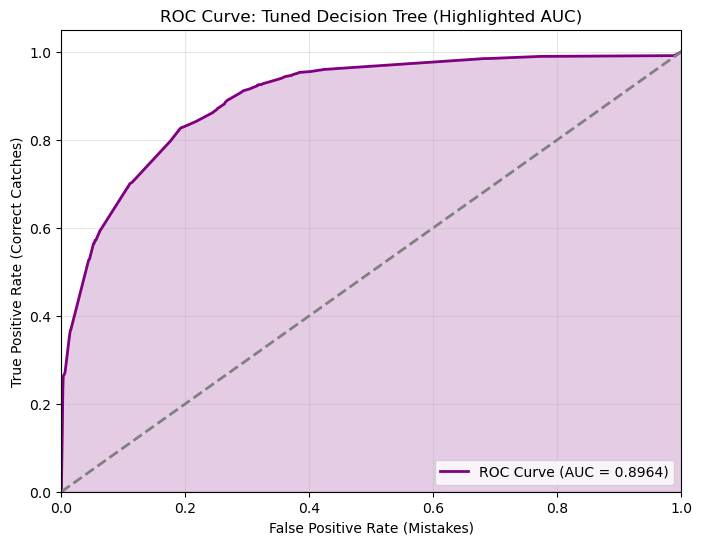

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Use the 'best_dt_model' we created with GridSearchCV
best_pred = best_dt_model.predict(X_test)
best_pred_proba = best_dt_model.predict_proba(X_test)[:, 1]
best_auc = roc_auc_score(y_test, best_pred_proba)

# 2. Print the text results
print("--- Model 4: Tuned Decision Tree Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, best_pred):.2%}")
print(f"Precision: {precision_score(y_test, best_pred):.2%}")
print(f"Recall:    {recall_score(y_test, best_pred):.2%}")
print(f"F1-Score:  {f1_score(y_test, best_pred):.2%}")
print(f"ROC-AUC:   {best_auc:.4f}")

# 3. Create the ROC Curve Plot with Highlighted Area
fpr, tpr, _ = roc_curve(y_test, best_pred_proba)

plt.figure(figsize=(8, 6))
# Plot the main purple line
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC Curve (AUC = {best_auc:.4f})')

# Fill the area under the curve to highlight the AUC
plt.fill_between(fpr, tpr, color='purple', alpha=0.2) 

# Plot the "Random Guesser" diagonal line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Formatting the chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Mistakes)')
plt.ylabel('True Positive Rate (Correct Catches)')
plt.title('ROC Curve: Tuned Decision Tree (Highlighted AUC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Accuracy: 85.14% - Here we have use the GridSearchCV which is making our accuracy higher than our initial tree because we allowed the tree to grow deeper to catch more patterns, but we used min_samples_split to make sure it didn't just memorize the data.

Precision: 77.49% - This tells that our model is 77% sure when pointed to a person that in which caterogry that person lies. this is less then initial decision tree which make it more agrrevie to look for people which lies in category have more then $50k income.

Recall: 57.12% - This shows our model caught about 57% people who are making more then $50k. this is 5% greatter then our initial decision tree which make it more reliable in finding person with high income, where our inital decision tree is lacking 

F1-Score: 65.77% - This is the average of precision and recall, This is Higher then Inital decision tree because here recall has increased significatly and precision doesn't decreased that much.

ROC-AUC: 0.8964 - This score tells us that our model is 0.89 times greater then guessing random output for the person income

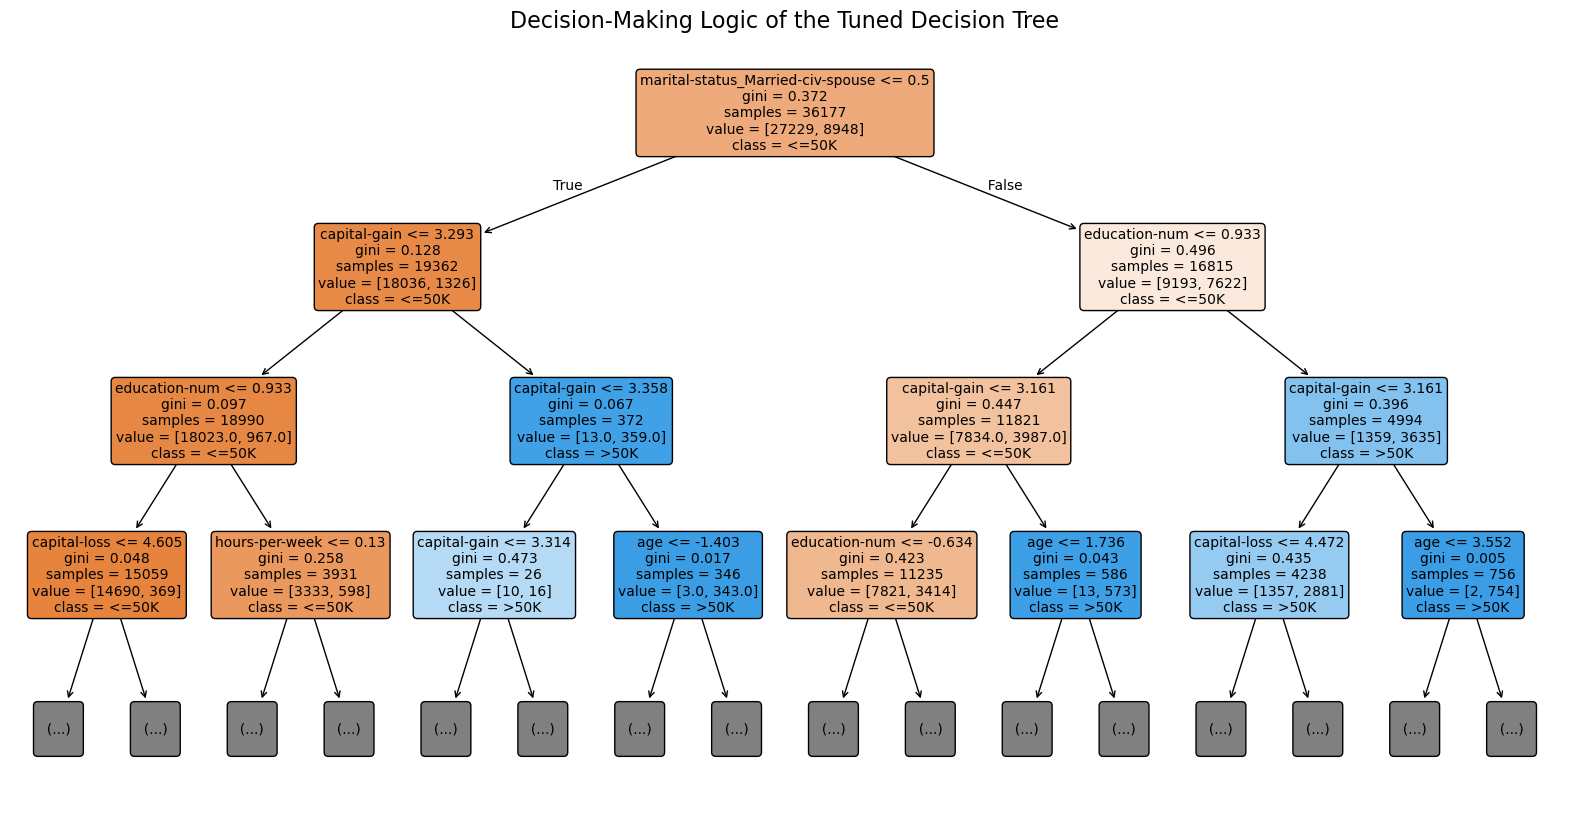

In [110]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# We use the 'best_dt_model' we trained after Hyperparameter Tuning
plt.figure(figsize=(20, 10))

plot_tree(best_dt_model, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=3) 

plt.title("Decision-Making Logic of the Tuned Decision Tree", fontsize=16)
plt.show()

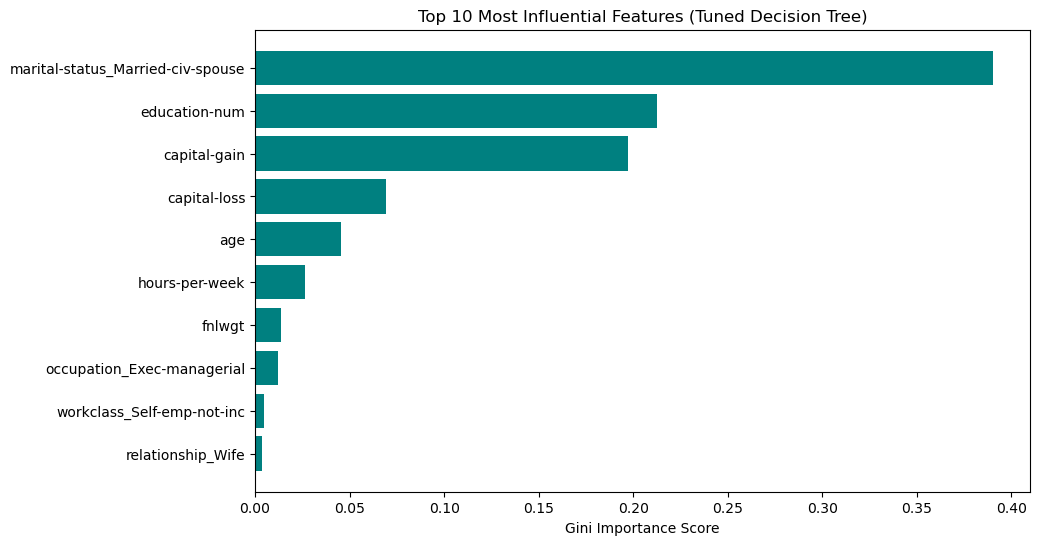

In [111]:
import numpy as np

# Extract importance scores from the tuned model
importances = best_dt_model.feature_importances_

# Organize into a DataFrame and sort for a horizontal bar plot
feat_import_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(feat_import_df['Feature'], feat_import_df['Importance'], color='teal')
plt.xlabel("Gini Importance Score")
plt.title("Top 10 Most Influential Features (Tuned Decision Tree)")
plt.show()

In [112]:
import pandas as pd

# Final Summary Table including all 5 core metrics
final_comparison = pd.DataFrame({
    "Model Stage": ["Initial Decision Tree", "Random Forest", "XGBoost", "Tuned Decision Tree"],
    "Accuracy": ["84.43%", "85.42%", "86.62%", "85.14%"],
    "Precision": ["78.40%", "80.73%", "79.10%", "77.49%"],
    "Recall": ["52.04%", "54.69%", "63.14%", "57.12%"],
    "F1-Score": ["62.55%", "65.21%", "70.23%", "65.77%"],
    "ROC-AUC": [0.8787, 0.9100, 0.9254, 0.8964]
})

print("--- FINAL ASSIGNMENT PERFORMANCE SUMMARY ---")
display(final_comparison)

--- FINAL ASSIGNMENT PERFORMANCE SUMMARY ---


,Model Stage,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Initial Decision Tree,84.43%,78.40%,52.04%,62.55%,0.8787
1,Random Forest,85.42%,80.73%,54.69%,65.21%,0.9100
2,XGBoost,86.62%,79.10%,63.14%,70.23%,0.9254
3,Tuned Decision Tree,85.14%,77.49%,57.12%,65.77%,0.8964


In [113]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


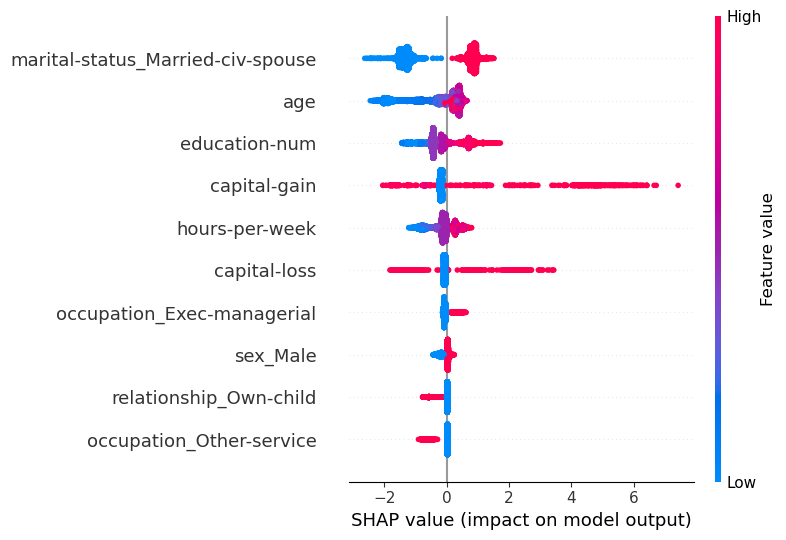

In [114]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the SHAP TreeExplainer for XGBoost
# This tool helps us "see inside" the complex XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 2. Calculate SHAP values for the test set
# This measures how much each feature pushed the income guess up or down
shap_values = explainer.shap_values(X_test)

# 3. Create a Summary Plot (Limited to Top 10)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, max_display=10)

CONCLUSION:
Our analysis proved that while a single Decision Tree is easy to visualize, it struggles to find all high-income individuals (low Recall). By moving to Ensemblage Methods like Random Forest and XGBoost, we significantly improved our results. XGBoost emerged as the most powerful model, showing that learning from errors sequentially is the best strategy for this dataset. Finally, using SHAP confirmed that Marital Status and Age are the most influential factors in determining income level in this census data.